In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import math
import sklearn.preprocessing
from sklearn.preprocessing import StandardScaler
import os
import subprocess as sp

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
np.random.seed(4)

from models import EarlyStopping, GRU
from utilities import get_NSE, MSE, get_colors, print_notes, inverse_transform_sp
from preprocess import load_data, SampleData

In [2]:
def get_gpu_memory():
    _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]
    ACCEPTABLE_AVAILABLE_MEMORY = 1024
    COMMAND = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = _output_to_list(sp.check_output(COMMAND.split()))[1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    return memory_free_values

if torch.cuda.is_available():
    device = torch.device("cuda")
if get_gpu_memory()[0] < 1500 :
    device = torch.device("cpu")
print(device)

# Get colors
colors = get_colors()

cuda


In [3]:
## Remove the comments to run the SWAT-SW experiment.
output_vars = ['SW_ENDmm']
run_task = 'Train_RMB_inf_IIF_SSIF_SW'

## Remove the comments to run the SWAT-SNO experiment.
# output_vars = ['SNOmm']
# run_task = 'Train_RMB_inf_IIF_SSIF_SNO'

## Remove the comments to run the SWAT-SF experiment.
# output_vars = ['Q_pred_mm']
# run_task = 'Train_RMB_inf_IIF_SSIF_SF'

sim_type = 'full_wsl'
rversion = 'hs32'
#----------------paths-------------------
res_dir = '../results/head_water_SWAT_1000_years/'
exp_dir = res_dir + '{}/rversion_{}/'.format(run_task, rversion)

#--------------------------------------------- load input data -----------------------------
new_data_dir = '../data/1000_year_simulation/'
if sim_type =='full_wsl':
    path = new_data_dir + 'head_water_SWAT_1000_years.csv'
elif sim_type =='nosnow_nofrozen_wsl':
    path = new_data_dir + 'head_water_SWAT_1000_years_no_snow_no_frozen.csv'
elif sim_type =='nosnow_wsl':
    path = new_data_dir + 'head_water_SWAT_1000_years_no_snow.csv'
else:
    raise FileNotFoundError

In [4]:
run_iter = 5
max_iter = run_iter
n_steps = 366
hidden_size = 32
epochs = 500
learning_rate = 0.01
n_classes = len(output_vars)
batch_size = 64
input_size = 7
dropout = 0
nlayers=1
patience = 50

input_vars = ['Date', 'PRECIPmm', 'TMP_MXdgC', 'TMP_MNdgC', 'SOLARMJ/m2', 'WINDM/s', 'RHmd']
assert(len(input_vars) == input_size)

params = np.load(exp_dir + 'params_ss_{}.npy'.format(n_steps),allow_pickle=True).tolist()
print("The network hypermeters : ")
for k,v in params.items():
    if k != "notes":
        print(k,v)
    if k == "notes":
        print()
        print_notes(params['notes'][0])

The network hypermeters : 
learning_rate 0.01
epochs 500
batch_size 64
hidden_size 32
input_size 7
n_steps 366
dropout 0.0
n_classes 1
num_samples_train 0
shift_train 183
num_samples_valid 0
shift_valid 183
num_samples_test 0
shift_test 183
train_percentage 0.5
valid_percentage 0.1

Goal: Simulate the target variable using 7 weather drivers including Date, PRECIPmm, TMP_MXdgC, TMP_MNdgC, SOLARMJ/m2, WINDM/s, RHmd
Target variables: SW_ENDmm, SNOmm, Q_pred_mm
Data: 1000 years simulation data
Split data: First 50% of data as the training set, middle 10% of data as the validation set,  last 40% of data as the testing set
Settings:
- Model: Random mini-batch algorithm
- Model: one layer GRU



In [5]:
df = pd.read_csv(path)
feat, label = load_data(df, output_vars, input_vars, input_size)

# First 50% of data as the training set, middle 10% of data as the validation set, last 40% of data as the testing set.
train_percentage = 0.5
valid_percentage = 0.1
test_percentage = 1 - (train_percentage + valid_percentage)

# Split data
T = feat.shape[0]
train_len = int(T*train_percentage)
valid_len = int(T*valid_percentage)
test_len = T - train_len - valid_len
print(train_len,valid_len,test_len)
train_x = feat[:train_len].copy()
train_y = label[:train_len].copy()
valid_x = feat[train_len:train_len+valid_len].copy()
valid_y = label[train_len:train_len+valid_len].copy()
test_x = feat[train_len+valid_len:].copy()
test_y = label[train_len+valid_len:].copy()

# Normalize data
scaler_x = StandardScaler()
scaler_x.fit(train_x) 
x_train = scaler_x.transform(train_x)
x_valid = scaler_x.transform(valid_x)
x_test = scaler_x.transform(test_x)
scaler_y = StandardScaler()
scaler_y.fit(train_y)
y_train = scaler_y.transform(train_y)
y_valid = scaler_y.transform(valid_y)
y_test = scaler_y.transform(test_y)

# Sample data
## Get indexes
train_idx = np.arange(len(y_train))
valid_idx = np.arange(len(y_valid))
test_idx = np.arange(len(y_test))
## Set stride
num_samples_train = 0
shift_train = int(n_steps / 2)
num_samples_valid = 0
shift_valid = int(n_steps / 2)
num_samples_test = 0
shift_test = int(n_steps / 2)
## Get lists of indexes to sample data. 
train_idx_arr = SampleData(train_idx,n_steps,shift_train,num_samples_train)
num_train_samples = train_idx_arr.shape[0]
valid_idx_arr = SampleData(valid_idx,n_steps,shift_valid,num_samples_valid)
num_valid_samples = valid_idx_arr.shape[0]
test_idx_arr = SampleData(test_idx,n_steps,shift_test,num_samples_test)
num_test_samples = test_idx_arr.shape[0]
## Sample data
x_train_sp_ = x_train[train_idx_arr,:]
y_train_sp_ = y_train[train_idx_arr,:]
m_train_sp_ = y_train_sp_.copy()
m_train_sp_[:,:,:] = 1 # no masking
x_valid_sp_ = x_valid[valid_idx_arr,:]
y_valid_sp_ = y_valid[valid_idx_arr,:]
m_valid_sp_ = y_valid_sp_.copy()
m_valid_sp_[:,:,:] = 1 # no masking
x_test_sp_ = x_test[test_idx_arr,:]
y_test_sp_ = y_test[test_idx_arr,:]
m_test_sp_ = y_test_sp_.copy()
m_test_sp_[:,:,:] = 1 # no masking

# Send data to the device
x_train_sp = torch.from_numpy(x_train_sp_).type(torch.float32).to(device)
y_train_sp = torch.from_numpy(y_train_sp_).type(torch.float32).to(device)
m_train_sp = torch.from_numpy(m_train_sp_).type(torch.float32).to(device)

x_valid_sp = torch.from_numpy(x_valid_sp_).type(torch.float32).to(device)
y_valid_sp = torch.from_numpy(y_valid_sp_).type(torch.float32).to(device)
m_valid_sp = torch.from_numpy(m_valid_sp_).type(torch.float32).to(device)

x_test_sp = torch.from_numpy(x_test_sp_).type(torch.float32).to(device)
y_test_sp = torch.from_numpy(y_test_sp_).type(torch.float32).to(device)
m_test_sp = torch.from_numpy(m_test_sp_).type(torch.float32).to(device)

182622 36524 146098
182622
36524
146098


In [6]:
# Analyze the training time
tot_epoch = 0
tot_time = 0
for run_iter in np.arange(max_iter):
    print('Iteration {}'.format(run_iter))
    # # Load the final epoch model
    path_save = exp_dir+"run_iter_{}_final_model.sav".format(run_iter)
    checkpoint=torch.load(path_save)
    epoch = checkpoint['epoch']
    training_time = checkpoint['train_time']
    tot_epoch += epoch
    tot_time += training_time
    print("Total epoch : {}".format(epoch))
    print("Total training time : {:.4f}".format(training_time))
    
print("{:.4f} second/epoch".format(tot_time / tot_epoch))

Iteration 0
Total epoch : 65
Total training time : 17.2368
Iteration 1
Total epoch : 72
Total training time : 14.3434
Iteration 2
Total epoch : 66
Total training time : 12.7235
Iteration 3
Total epoch : 73
Total training time : 14.6739
Iteration 4
Total epoch : 63
Total training time : 12.1859
0.2099 second/epoch


# RMB-IIF Strategy

In [7]:
pred_train_itrs = []
hiddens_train_itrs = []
pred_test_itrs = []
hiddens_test_itrs = []

for run_iter in np.arange(max_iter):
    print('Iteration {}'.format(run_iter))
    # Load the best validation model
    path_save = exp_dir+"run_iter_{}_best_model.sav".format(run_iter)
    checkpoint=torch.load(path_save)
    model_trained=GRU(input_size, hidden_size, nlayers, n_classes, dropout)
    model_trained.load_state_dict(checkpoint['model_state_dict'])
    model_trained.to(device)
    epoch = checkpoint['epoch']
    print("Best epoch is {}".format(epoch))
    with torch.no_grad():
        model_trained.eval()
        hidden_head = model_trained.init_hidden(num_train_samples)
        pred_train,hiddens_train = model_trained(x_train_sp,hidden_head)
        hidden_head = model_trained.init_hidden(num_test_samples)
        pred_test,hiddens_test = model_trained(x_test_sp,hidden_head)

        loss_train = MSE(pred_train, y_train_sp, m_train_sp).cpu().numpy()
        loss_test = MSE(pred_test, y_test_sp, m_test_sp).cpu().numpy()
        # print("Epoch {} : epoch_loss_train RMSE loss {:.4f}".format(str(epoch), np.sqrt(loss_train)))
        # print("Epoch {} : epoch_loss_test RMSE loss {:.4f}".format(str(epoch), np.sqrt(loss_test)))
        # print()
        pred_train = pred_train.cpu().numpy()
        pred_test = pred_test.cpu().numpy()
        hiddens_test = hiddens_test.cpu().numpy()
        hiddens_train = hiddens_train.cpu().numpy()
    
    # Transform the output back to the original scale.
    pred_train, y_train_ori = inverse_transform_sp(pred_train, y_train_sp.cpu().numpy(), scaler_y, n_classes)
    pred_test, y_test_ori = inverse_transform_sp(pred_test, y_test_sp.cpu().numpy(), scaler_y,n_classes)
    pred_train_itrs.append(pred_train)
    hiddens_train_itrs.append(hiddens_train)
    pred_test_itrs.append(pred_test)
    hiddens_test_itrs.append(hiddens_test)

Iteration 0
Best epoch is 15
Iteration 1
Best epoch is 22
Iteration 2
Best epoch is 16
Iteration 3
Best epoch is 23
Iteration 4
Best epoch is 13


## Sequence Analysis

In [8]:
'''
This code block inverse_transform predictions to the original scale.
'''
y_sp = np.squeeze(y_test_sp.cpu().numpy())
m_sp = np.squeeze(m_test_sp.cpu().numpy())
y_ori =  y_sp.reshape(-1,n_classes)
y_ori = scaler_y.inverse_transform(y_ori).reshape(y_sp.shape)
idx_arr = test_idx_arr

In [9]:
with open(exp_dir + "pred_test_itrs.npy", 'wb') as f:
    np.save(f, pred_test_itrs)
with open(exp_dir + "test_idx_arr.npy", 'wb') as f:
    np.save(f, test_idx_arr)
with open(exp_dir + "y_ori.npy", 'wb') as f:
    np.save(f, y_ori)

In [10]:
rmses_test = []
for pred_test in pred_test_itrs:
    rmses_test.append(np.sqrt(MSE(pred_test, y_ori, m_sp)))

rmses_test = np.asarray(rmses_test)
print("Test RMSE")
print(np.round(rmses_test,3))
print("Test RMSE Mean : {:.3f}".format(np.mean(rmses_test),3))
print("Test RMSE STDV : {:.3f}".format(np.std(rmses_test),3))

Test RMSE
[32.505 32.898 32.664 32.903 33.039]
Test RMSE Mean : 32.802
Test RMSE STDV : 0.191


In [11]:
NSE_test = []
for pred_test in pred_test_itrs:
    NSE_test.append(get_NSE(y_ori, pred_test))

NSE_test = np.asarray(NSE_test)
print("Test NSE")
print(np.round(NSE_test,4))
print("Test NSE Mean : {:.3f}".format(np.mean(NSE_test)))
print("Test NSE STDV : {:.3f}".format(np.std(NSE_test)))

Test NSE
[0.6333 0.6243 0.6297 0.6242 0.6211]
Test NSE Mean : 0.627
Test NSE STDV : 0.004


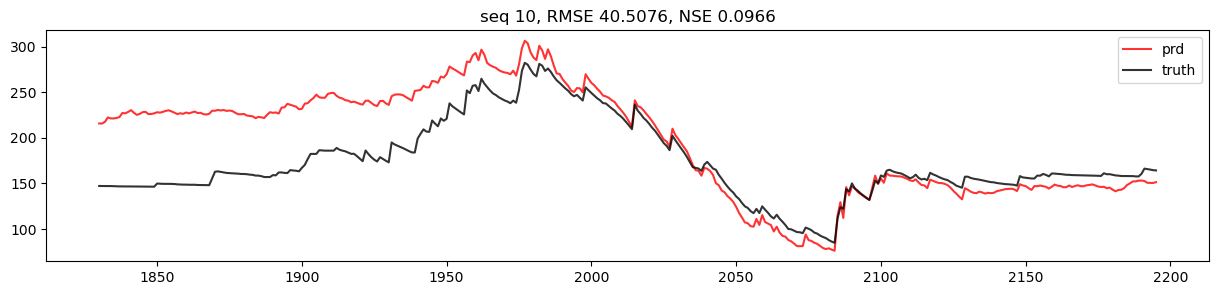

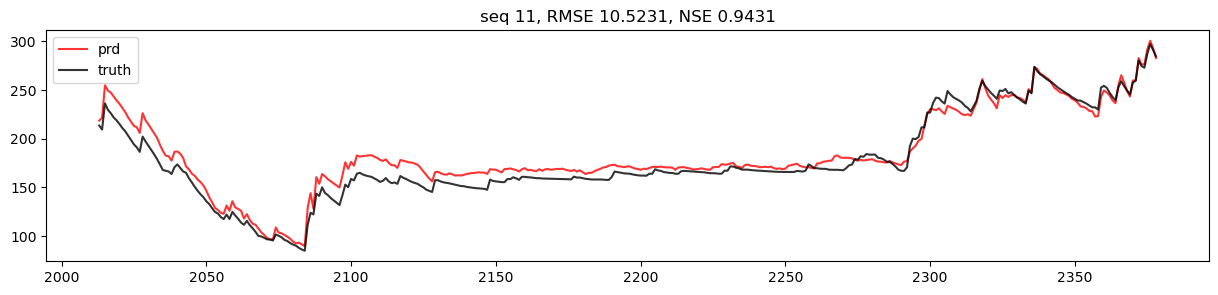

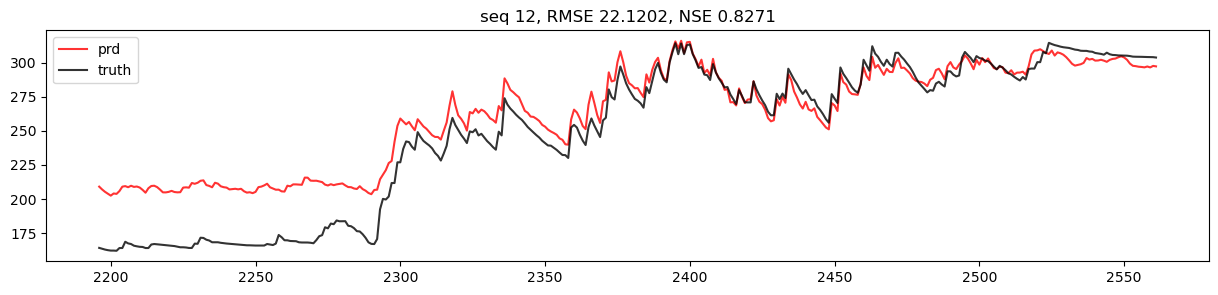

In [12]:
pred = pred_test_itrs[0]
for i in range(10,13):
    '''Static plot
    '''
    ig,ax = plt.subplots(1,1, figsize=(15,3))
    ax.plot(idx_arr[i],pred[i],c='r', alpha=0.8,label='prd')
    ax.plot(idx_arr[i],y_ori[i],c='black',alpha=0.8, label='truth')
    plt.title("seq {}, RMSE {:.4f}, NSE {:.4F}".format(i, np.sqrt(MSE(y_ori[i], pred[i], m_sp[i])), get_NSE(y_ori[i], pred[i])))
    plt.legend()
    plt.show()
    plt.close()

## Time Series Analysis
In this experiment, predicted sequences are post-processed back into the time series format. For example, if the predicted sequences overlap 183 days, we discarded the first half of each predicted sequence, except for the first sequence, and combined the last 183 timesteps from sequences to reconstruct the time series.

In [13]:
def get_pred_agg(pred, y, hiddens_list,idx_arr, keep='last_half'):
    '''
    Aggregate the prediction sequence. On testing.
    '''
    pred_agg = np.zeros(y.shape)
    hidden_list_agg = np.zeros((y.shape[0], hiddens_list.shape[-1]))
    
    if len(pred.shape) == 2:
        pred = np.expand_dims(pred, axis=2)

    assert(len(pred.shape) == 3)
    
    cnt = np.zeros(y.shape)
    cnt_hidden = np.zeros(hidden_list_agg.shape)
    
    # Keep the last half
    if keep == 'last_half':
        for i in range(len(pred)):
            if i == 0:
                cidx = idx_arr[i,:]
                pred_agg[cidx] = pred[i,:,:]
                hidden_list_agg[cidx] = hiddens_list[i,:,:]

            else:
                cidx = idx_arr[i][int(n_steps/2):]
                pred_agg[cidx] = pred_agg[cidx] + pred[i,int(n_steps/2):,:]
                hidden_list_agg[cidx] = hiddens_list[i,int(n_steps/2):,:]

            cnt[cidx] = cnt[cidx] + 1
            cnt_hidden[cidx] = cnt_hidden[cidx] + 1
    elif keep == 'first_half':
        for i in range(len(pred)):
            if i == len(pred)-1:
                cidx = idx_arr[i,:]
                pred_agg[cidx] = pred[i,:,:]
                hidden_list_agg[cidx] = hiddens_list[i,:,:]

            else:
                cidx = idx_arr[i][:int(n_steps/2)]
                pred_agg[cidx] = pred_agg[cidx] + pred[i,:int(n_steps/2),:]
                hidden_list_agg[cidx] = hiddens_list[i,:int(n_steps/2),:]

            cnt[cidx] = cnt[cidx] + 1
            cnt_hidden[cidx] = cnt_hidden[cidx] + 1

    assert(np.all(cnt>0))
    assert(np.all(cnt_hidden > 0))
    
    pred_agg = pred_agg*1.0/cnt
    hidden_list_agg = hidden_list_agg*1.0 / cnt_hidden
    return pred_agg, hidden_list_agg

In [14]:
pred_test_agg_itrs = []
hiddens_test_agg_itrs = []

for pred_test in pred_test_itrs:
    pred_test_agg, hiddens_test_agg = get_pred_agg(pred_test, test_y, hiddens_test, test_idx_arr)
    pred_test_agg_itrs.append(pred_test_agg)
    hiddens_test_agg_itrs.append(hiddens_test_agg)

pred_test_agg_itrs = np.asarray(pred_test_agg_itrs)
hiddens_test_agg_itrs = np.asarray(hiddens_test_agg_itrs)

with open(exp_dir + "pred_test_agg_itrs.npy", 'wb') as f:
    np.save(f, pred_test_agg_itrs)
    
with open(exp_dir + "test_y.npy", 'wb') as f:
    np.save(f, test_y)
    
rmses_test_itrs = np.zeros((len(pred_test_itrs),n_classes))
for run_iter in range(max_iter):
    for j in range(n_classes):
        rmses_test_itrs[run_iter,j] = np.sqrt(MSE(pred_test_agg_itrs[run_iter,:,j],test_y[:,j]))


nse_test_itrs = np.zeros((len(pred_test_itrs),n_classes))
for run_iter in range(max_iter):
    for j in range(n_classes):
        nse_test_itrs[run_iter,j] = get_NSE(test_y[:,j],pred_test_agg_itrs[run_iter,:,j])

print("Last half ")
for j in range(n_classes):
    print('{} Test RMSE'.format(output_vars[j]))
    print(rmses_test_itrs[:,j].reshape(-1,1))
    print(np.round(np.mean(rmses_test_itrs[:,j]),3))
    print(np.round(np.std(rmses_test_itrs[:,j]),3))

print()
print("Last half ")
for j in range(n_classes):
    print('{} Test NSE'.format(output_vars[j]))
    print(nse_test_itrs[:,j].reshape(-1,1))
    print(np.round(np.mean(nse_test_itrs[:,j]),3))
    print(np.round(np.std(nse_test_itrs[:,j]),3))

Last half 
SW_ENDmm Test RMSE
[[24.40836016]
 [25.19848362]
 [24.83213451]
 [25.23351075]
 [25.60272234]]
25.055
0.405

Last half 
SW_ENDmm Test NSE
[[0.79323382]
 [0.77963069]
 [0.78599181]
 [0.77901762]
 [0.77250357]]
0.782
0.007


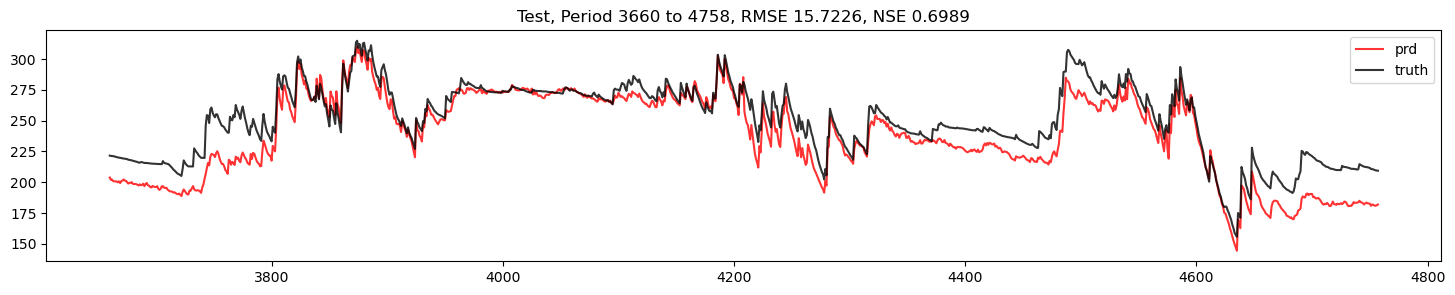

In [15]:
import seaborn as sns
pred_test_agg = pred_test_agg_itrs[0]
hidden_list_test_agg = hiddens_test_agg_itrs[0]
output_vars = np.asarray(output_vars)
output_var = output_vars[0]
idx = np.where(output_vars == output_var)[0][0]
pred_agg = pred_test_agg[:,idx]
y = test_y[:,idx]
x = test_x[:,:]
hidden_agg = hidden_list_test_agg.copy()

low = 366*10
high = 366*13
period = np.arange(low,high)
pred_snippet = pred_agg[period]
y_snippet = y[period]
x_snippet = x[period]
ig,ax = plt.subplots(1,1, figsize=(18,3))
ax.plot(period,pred_snippet,c='r',alpha=0.8, label='prd')
ax.plot(period,y_snippet,c='black',alpha=0.8, label='truth')
plt.title("Test, Period {} to {}, RMSE {:.4f}, NSE {:.4f}".format(low,high, np.sqrt(MSE(pred_snippet, y_snippet)), get_NSE(y_snippet, pred_snippet)))
plt.legend()
plt.show()
plt.close()

## RMB-IIF Analysis daily RMSE

In [16]:
dates = df['Date'].values
doys = np.array([datetime.strptime(cdate, '%Y-%m-%d').date().timetuple().tm_yday for cdate in dates])

pred_test_agg = pred_test_agg_itrs[0]
output_vars = np.asarray(output_vars)
output_var = output_vars[0]
idx = np.where(output_vars == output_var)[0][0]

doy = doys[train_len+valid_len:]
pred_agg = pred_test_agg[:,idx]
y = test_y[:,idx]

In [17]:
df_res = pd.DataFrame(data = {'doy':doy, 'pred':pred_agg, 'obs':y})
daily_rmses = []
assert(min(df_res['doy'])==1 and max(df_res['doy'])==366)
for i in range(1, 367):
    chunk = df_res[df_res['doy'] == i]
    daily_rmses.append(np.sqrt(MSE(chunk['pred'], chunk['obs'])))

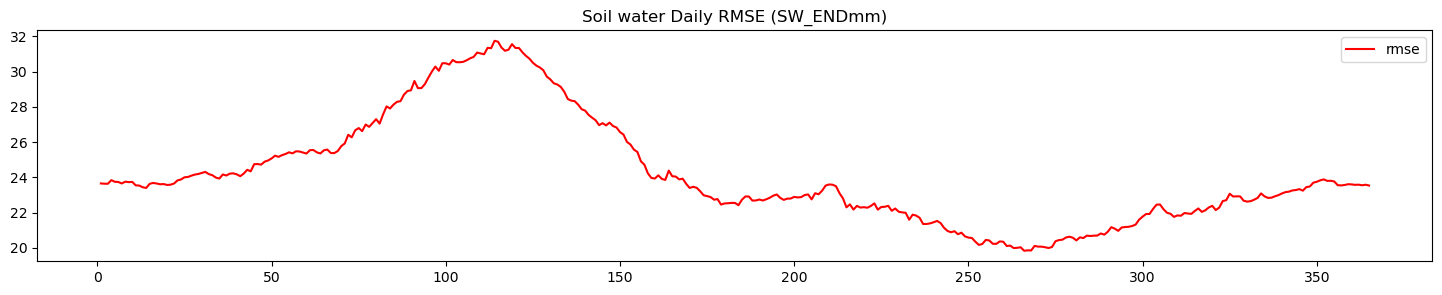

In [18]:
ig,ax = plt.subplots(1,1, figsize=(18,3))
ax.plot(np.arange(1,366),daily_rmses[:365],c='r', label='rmse')
plt.title("Soil water Daily RMSE ({})".format(output_var))
plt.legend()
plt.show()
plt.close()

# RMB-SSIF Strategy


In [19]:
pred_train_itrs = []
hiddens_train_itrs = []
pred_test_itrs = []
hiddens_test_itrs = []
rmses_train_itrs = []
rmses_test_itrs = []

In [20]:
for run_iter in np.arange(max_iter):
    print('Iteration {}'.format(run_iter))
    # Load the best validation model
    path_save = exp_dir+"run_iter_{}_best_model.sav".format(run_iter)
    checkpoint=torch.load(path_save)
    model_trained=GRU(input_size, hidden_size, nlayers, n_classes, dropout)
    model_trained.load_state_dict(checkpoint['model_state_dict'])
    model_trained.to(device)
    epoch = checkpoint['epoch']
    print("Best epoch is {}".format(epoch))
    
    with torch.no_grad():
        model_trained.eval()
        hidden_head = model_trained.init_hidden(1)
        X = torch.from_numpy(np.expand_dims(x_train,0)).type(torch.float32).to(device)
        pred_train,hiddens_train = model_trained(X,hidden_head)
        hidden_head = model_trained.init_hidden(1)
        X = torch.from_numpy(np.expand_dims(x_test,0)).type(torch.float32).to(device)
        pred_test,hiddens_test = model_trained(X,hidden_head)
        
        pred_test = pred_test.cpu().numpy().reshape(-1,1)
        pred_train = pred_train.cpu().numpy().reshape(-1,1)
        hiddens_test = np.squeeze(hiddens_test.cpu().numpy())
        hiddens_train = np.squeeze(hiddens_train.cpu().numpy())
        
        pred_train = scaler_y.inverse_transform(pred_train)
        pred_test = scaler_y.inverse_transform(pred_test)
        
        loss_train = MSE(pred_train, train_y)
        loss_test = MSE(pred_test, test_y)
        rmses_train_itrs.append(np.sqrt(loss_train))
        rmses_test_itrs.append(np.sqrt(loss_test))
        print("Epoch {} : epoch_loss_train RMSE loss {:.4f}".format(str(epoch), np.sqrt(loss_train)))
        print("Epoch {} : epoch_loss_test RMSE loss {:.4f}".format(str(epoch), np.sqrt(loss_test)))
        print()
    
    pred_train_itrs.append(pred_train)
    hiddens_train_itrs.append(hiddens_train)
    pred_test_itrs.append(pred_test)
    hiddens_test_itrs.append(hiddens_test)

Iteration 0
Best epoch is 15
Epoch 15 : epoch_loss_train RMSE loss 17.5724
Epoch 15 : epoch_loss_test RMSE loss 19.1806

Iteration 1
Best epoch is 22
Epoch 22 : epoch_loss_train RMSE loss 17.8283
Epoch 22 : epoch_loss_test RMSE loss 19.7831

Iteration 2
Best epoch is 16
Epoch 16 : epoch_loss_train RMSE loss 17.3244
Epoch 16 : epoch_loss_test RMSE loss 19.7562

Iteration 3
Best epoch is 23
Epoch 23 : epoch_loss_train RMSE loss 16.9513
Epoch 23 : epoch_loss_test RMSE loss 20.1652

Iteration 4
Best epoch is 13
Epoch 13 : epoch_loss_train RMSE loss 20.0579
Epoch 13 : epoch_loss_test RMSE loss 21.4093



In [21]:
rmses_test_itrs = np.asarray(rmses_test_itrs)
rmses_train_itrs = np.asarray(rmses_train_itrs)

In [22]:
with open(exp_dir + "pred_test_agg_stateful_itrs.npy", 'wb') as f:
    np.save(f, pred_test_itrs)

In [23]:
print("Test RMSE Mean")
print(np.round(rmses_test_itrs,3))
print("Test RMSE Mean : {:.3f}".format(np.mean(rmses_test_itrs)))
print("Test RMSE STDV : {:.3f}".format(np.std(rmses_test_itrs)))

Test RMSE Mean
[19.181 19.783 19.756 20.165 21.409]
Test RMSE Mean : 20.059
Test RMSE STDV : 0.745


In [24]:
NSE_test = []
for pred_test in pred_test_itrs:
    NSE_test.append(get_NSE(test_y, pred_test))

NSE_test = np.asarray(NSE_test)
print("Test NSE")
print(np.round(NSE_test,3))
print("Test NSE Mean : {:.3f}".format(np.mean(NSE_test)))
print("Test NSE STDV : {:.3f}".format(np.std(NSE_test)))

Test NSE
[0.872 0.864 0.865 0.859 0.841]
Test NSE Mean : 0.860
Test NSE STDV : 0.011


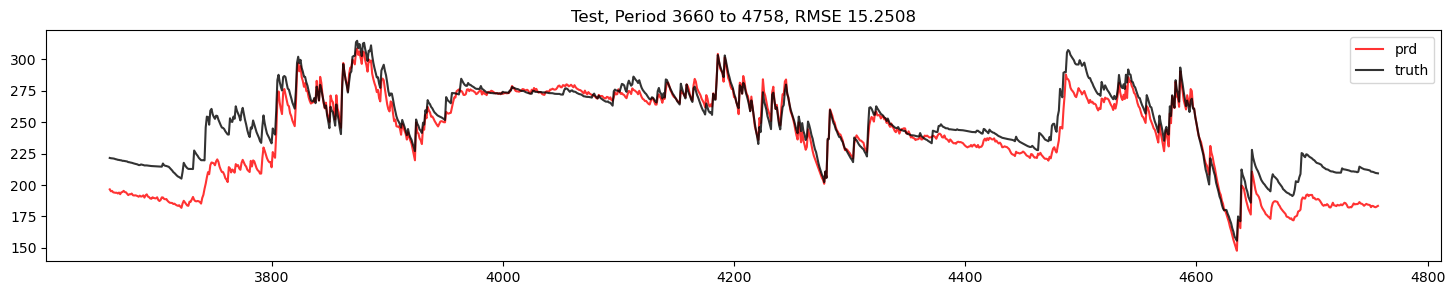

In [25]:
pred_test_agg = pred_test_itrs[0]
hidden_list_test_agg = hiddens_test_itrs[0]

output_vars = np.asarray(output_vars)
output_var = output_vars[0]
idx = np.where(output_vars == output_var)[0][0]
pred_agg = pred_test_agg[:,idx]
y = test_y[:,idx]
x = test_x[:,:]
hidden_agg = hidden_list_test_agg.copy()


low = 366*10
high = 366*13
period = np.arange(low,high)
pred_snippet = pred_agg[period]
y_snippet = y[period]
x_snippet = x[period]

ig,ax = plt.subplots(1,1, figsize=(18,3))
ax.plot(period,pred_snippet,c='r',alpha=0.8, label='prd')
ax.plot(period,y_snippet,c='black',alpha=0.8, label='truth')
plt.title("Test, Period {} to {}, RMSE {:.4f}".format(low,high, np.sqrt(MSE(pred_snippet, y_snippet))))
plt.legend()
plt.show()
plt.close()

## RMB-SSIF - Analysis daily RMSE

In [26]:
dates = df['Date'].values
doys = np.array([datetime.strptime(cdate, '%Y-%m-%d').date().timetuple().tm_yday for cdate in dates])

pred_test_agg = pred_test_itrs[0]
output_vars = np.asarray(output_vars)
output_var = output_vars[0]
idx = np.where(output_vars == output_var)[0][0]

doy = doys[train_len+valid_len:]
pred_agg = pred_test_agg[:,idx]
y = test_y[:,idx]

In [27]:
df_res = pd.DataFrame(data = {'doy':doy, 'pred':pred_agg, 'obs':y})
daily_rmses = []
assert(min(df_res['doy'])==1 and max(df_res['doy'])==366)
for i in range(1, 367):
    chunk = df_res[df_res['doy'] == i]
    daily_rmses.append(np.sqrt(MSE(chunk['pred'], chunk['obs'])))

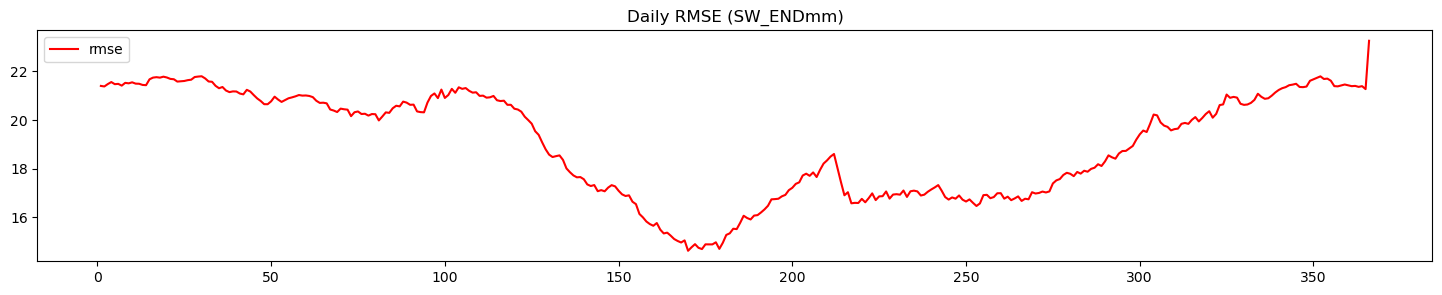

In [28]:
ig,ax = plt.subplots(1,1, figsize=(18,3))
ax.plot(np.arange(1,367),daily_rmses,c='r', label='rmse')
plt.title("Daily RMSE ({})".format(output_var))
plt.legend()
plt.show()
plt.close()